# How to use finite volume dispersion model in pyELQ
This example is intended to provide an overview on how to use the finite volume dispersion model in pyELQ to do a forward simulation in the presence of obstacle to calculate the concentration.

First, we import all the required packages.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as figure_factory

from scipy.spatial import cKDTree
from IPython.display import clear_output
from pyelq.coordinate_system import ENU
from pyelq.dispersion_model.finite_volume import FiniteVolume, FiniteVolumeDimension
from pyelq.dispersion_model.site_layout import SiteLayout
from pyelq.gas_species import CH4
from pyelq.meteorology.meteorology import Meteorology
from pyelq.meteorology.meteorology_windfield import MeteorologyWindfield
from pyelq.source_map import SourceMap

## Basic Setup
Basic setup of site limits and time

In [2]:
time_axis = pd.date_range(start="2024-01-01 08:00:00", end="2024-01-01 08:30:00", freq="10s").array
nof_observations = time_axis.size
reference_latitude = 0
reference_longitude = 0
reference_altitude = 0

site_limits = np.array([[0, 30], [0, 30], [0, 10]])

gas_object = CH4()

Next, we simulate the meteorological conditions. To keep things simple, we use a half-circle of wind directions, with a linearly varying wind speed.

In [3]:
met_object = Meteorology()
random_generator = np.random.default_rng(0)
met_object.time = time_axis

met_object.wind_speed = np.linspace(2.0, 4.0, nof_observations)
met_object.wind_direction = np.linspace(0, 180, nof_observations)
met_object.calculate_uv_from_wind_speed_direction()
met_object.w_component = 0.0 * random_generator.normal(size=nof_observations)
met_object.temperature = (273.1 + 15.0) * np.ones_like(met_object.wind_direction)
met_object.pressure = 101.325 * np.ones_like(met_object.wind_direction)

fig_wind = met_object.plot_polar_hist()
fig_wind.update_layout(height=400, margin={"r": 0, "l": 0})
fig_wind.show()

### Defining the Site Layout with Obstacles
Now we define the sitelayout with obstacles. The SiteLayout class represents cylindrical obstacles within the domain, which can influence wind flow and dispersion patterns. These obstacles are defined by their coordinates and radii:

- cylinder_coordinates: An ENU object specifying the east, north positions and height each cylinder relative to a reference latitude, longitude, and altitude.
- cylinder_radius: An array containing the radius of each cylinder.

In this example, two cylindrical obstacles are placed at:
- (east=3, north=19, up=5) with radius 2 m
- (east=13, north=2, up=7) with radius 1 m

These obstacles will later be used to mask grid cells within their radius, ensuring the dispersion model accounts for blocked regions when computing flow and coupling.


In [4]:
cylinder_coordinates = ENU(
    ref_latitude=reference_latitude, ref_longitude=reference_longitude, ref_altitude=reference_altitude
)
cylinder_coordinates.east = np.array([3, 13])
cylinder_coordinates.north = np.array([19, 2])
cylinder_coordinates.up = np.array([5, 7])
cylinder_radius = np.array([[2, 1]]).T

site_layout = SiteLayout(cylinder_coordinates=cylinder_coordinates, cylinder_radius=cylinder_radius)

## Forward Simulation

### Setting Up 2D Finite Volume Dimensions

As the forward model, we define a two-dimensional finite volume grid using a custom FiniteVolumeDimension data class. Each dimension (x, y) is characterized by the number of cells, spatial limits, and boundary conditions. For the x and y directions, we use 30 cells each and apply Dirichlet boundary conditions on the external boundaries, which typically fix the variable values at the domain edges.

In [5]:
dimensions = [
    FiniteVolumeDimension(
        "x",
        number_cells=30,
        limits=site_limits[0],
        external_boundary_type=["dirichlet"],
    ),
    FiniteVolumeDimension(
        "y",
        number_cells=30,
        limits=site_limits[1],
        external_boundary_type=["dirichlet"],
    ),
]

The dimensions are passed into a FiniteVolume object. On initialisation this object defines a grid and works out the neighbourhood and boundary relationships used in the model

In [6]:
diffusion_coefficients = np.array([0.1, 0.1, 1.0])
source_map = SourceMap()
source_map.location = ENU(
    ref_latitude=reference_latitude, ref_longitude=reference_longitude, ref_altitude=reference_altitude
)
fe_forward = FiniteVolume(
    source_map=source_map,
    dimensions=dimensions,
    diffusion_constants=diffusion_coefficients,
    minimum_contribution=1e-6,
    use_lookup_table=False,
    dt=0.1,
    site_layout=site_layout,
)

The wind field can be computed for a given time_index using the calculate_spatial_wind_field function at the gridcoordinates defined in the fe_forward object.

Text(0.5, 1.0, 'Wind Field at time=0')

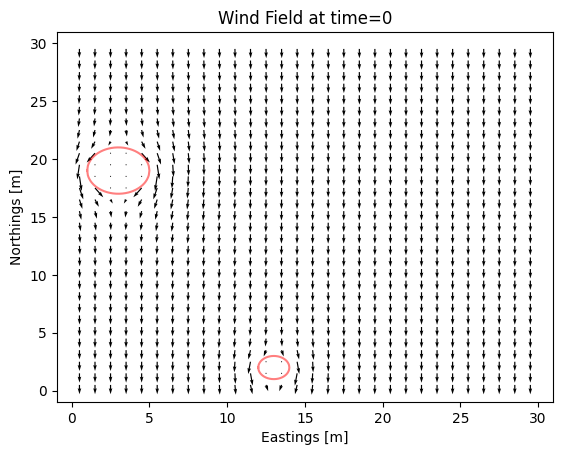

In [9]:
met_windfield = MeteorologyWindfield(static_wind_field=met_object, site_layout=site_layout)

met_windfield.calculate_spatial_wind_field(grid_coordinates=fe_forward.grid_coordinates, time_index=0)


x_cylinder = np.linspace(-cylinder_radius, cylinder_radius, 100)
y_cylinder = np.sqrt(cylinder_radius**2 - x_cylinder**2)
y_cylinder = np.concatenate((y_cylinder, -y_cylinder[::-1]))
x_cylinder = np.concatenate((x_cylinder, x_cylinder[::-1]))

plt.quiver(
    fe_forward.grid_coordinates.east,
    fe_forward.grid_coordinates.north,
    met_windfield.u_component,
    met_windfield.v_component,
)
for i in range(len(cylinder_coordinates.east)):
    plt.plot(
        (x_cylinder[:, i, :] + cylinder_coordinates.east[i]),
        (y_cylinder[:, i, :] + cylinder_coordinates.north[i]),
        c="red",
        alpha=0.5,
    )
plt.xlabel("Eastings [m]")
plt.ylabel("Northings [m]")

plt.title("Wind Field at time=0")

In [27]:
met_windfield = MeteorologyWindfield(static_wind_field=met_object, site_layout=site_layout)
met_windfield.calculate_spatial_wind_field(
    grid_coordinates=fe_forward.grid_coordinates,
    time_index=0
)

x_cylinder = np.linspace(-cylinder_radius, cylinder_radius, 100)
y_cylinder = np.sqrt(cylinder_radius**2 - x_cylinder**2)
y_cylinder = np.concatenate((y_cylinder, -y_cylinder[::-1]))
x_cylinder = np.concatenate((x_cylinder, x_cylinder[::-1]))

cylinder_line_traces = []
for i in range(len(cylinder_coordinates.east)):
    cylinder_line_traces.append(
        go.Scatter(
            x=(x_cylinder[:, i, :] + cylinder_coordinates.east[i]).ravel(),
            y=(y_cylinder[:, i, :] + cylinder_coordinates.north[i]).ravel(),
            mode="lines",
            line={"color": "red", "width": 2},
            opacity=0.5,
            showlegend=False,
            hoverinfo="skip"
        )
    )

fig = figure_factory.create_quiver(
    fe_forward.grid_coordinates.east, fe_forward.grid_coordinates.north,
    met_windfield.u_component, met_windfield.v_component,
    scale=0.3,
    arrow_scale=0.4,
    line_color="black"
)

fig.add_traces(cylinder_line_traces)
fig.update_layout(showlegend=False)

fig.update_layout(
    title="Wind Field at time=0",
    xaxis={
        "title": "Eastings [m]",
        "constrain": "domain"
    },
    yaxis={
        "title": "Northings [m]",
        "constrain": "domain"
    },
    width=900,
    height=900
)

fig.show()


The model is simulated forward by using the compute_forward_matrix function and a forward propogate loop. Emissions are added at a rate of 5.0 kg/hr at the location [15, 10] 

In [26]:
concentration = np.full((fe_forward.total_number_cells, met_object.nof_observations + 1), np.nan)
concentration[:, 0] = 0.0
source_allocation = np.zeros((fe_forward.total_number_cells, 1), dtype=bool)
source_location = np.array([15, 10])
source_rate = 5.0  # kg/hr
tree = cKDTree(np.vstack((fe_forward.grid_coordinates.east.flatten(), fe_forward.grid_coordinates.north.flatten())).T)
_, source_index = tree.query(source_location[:2], k=1)
source_allocation[source_index] = True

# Precompute convenience references
x_centers = fe_forward.dimensions[0].cell_centers
y_centers = fe_forward.dimensions[1].cell_centers
grid_size = fe_forward.grid_size

frames = []
initial_heatmap = None
initial_source_trace = None

for iT in range(met_object.nof_observations):
    met_windfield.calculate_spatial_wind_field(grid_coordinates=fe_forward.grid_coordinates, time_index=iT)
    fe_forward.compute_forward_matrix(met_windfield)
    s_smoothed = source_allocation * (source_rate / 3600.0)
    concentration[:, iT + 1] = (fe_forward.dt / fe_forward.cell_volume) * (
        fe_forward.forward_matrix @ concentration[:, iT].reshape(-1, 1) + s_smoothed
    ).flatten()

    if iT % 3 != 0:
        continue

    concentration_scaled = concentration[:, iT + 1] * (1e6) / gas_object.gas_density()
    z = concentration_scaled.reshape(grid_size).T
    zmin = float(np.nanmin(concentration_scaled))
    zmax = float(0.5 * np.nanmax(concentration_scaled))

    heatmap = go.Heatmap(
        x=x_centers,
        y=y_centers,
        z=z,
        colorscale="Jet",
        zmin=zmin,
        zmax=zmax,
        colorbar={"title": "Concentration (ppm)"},
        showscale=True
    )

    source_trace = go.Scatter(
        x=[source_location[0]],
        y=[source_location[1]],
        mode="markers",
        marker={"color": "black", "size": 10, "symbol": "x"},
        name="Source"
    )

    frame = go.Frame(
        data=[heatmap, source_trace],
        name=f"t={iT}",
        traces=[0, 1]
    )
    frames.append(frame)

    if initial_heatmap is None:
        initial_heatmap = heatmap
        initial_source_trace = source_trace

fig = go.Figure(
    data=[
        (
            initial_heatmap
            if initial_heatmap is not None
            else go.Heatmap(
                x=x_centers,
                y=y_centers,
                z=np.zeros(grid_size).T,
                colorscale="Jet",
                showscale=True
            )
        ),
        (
            initial_source_trace
            if initial_source_trace is not None
            else go.Scatter(
                x=[source_location[0]],
                y=[source_location[1]],
                mode="markers",
                marker={"color": "black", "size": 10, "symbol": "x"},
                name="Source"
            )
        ),
        *cylinder_line_traces
    ],
    layout=go.Layout(
        title="Concentration over time",

        xaxis={
            "title": "x (m)",
            "autorange": False,
            "range": [x_centers.min(), x_centers.max()],
            "constrain": "domain",
            "scaleanchor": "y",
            "scaleratio": 1
        },
        yaxis={
            "title": "y (m)",
            "autorange": False,
            "range": [y_centers.min(), y_centers.max()],
            "constrain": "domain"
        },

        updatemenus=[
            {
                "type": "buttons",
                "showactive": False,
                "x": 0.05,
                "y": 1.06,
                "xanchor": "left",
                "yanchor": "top",
                "direction": "left",
                "buttons": [
                    {
                        "label": "▶ Play",
                        "method": "animate",
                        "args": [
                            None,
                            {
                                "frame": {"duration": 200, "redraw": True},
                                "transition": {"duration": 0},
                                "fromcurrent": True
                            }
                        ]
                    },
                    {
                        "label": "⏸ Pause",
                        "method": "animate",
                        "args": [
                            [None],
                            {
                                "frame": {"duration": 0, "redraw": False},
                                "mode": "immediate",
                                "transition": {"duration": 0}
                            }
                        ]
                    }
                ]
            }
        ],

        sliders=[
            {
                "active": 0,
                "x": 0.1,
                "y": -0.07,
                "xanchor": "left",
                "yanchor": "top",
                "currentvalue": {"prefix": "Time step: "},
                "steps": [
                    {
                        "label": f.name,
                        "method": "animate",
                        "args": [
                            [f.name],
                            {
                                "mode": "immediate",
                                "frame": {"duration": 0, "redraw": True},
                                "transition": {"duration": 0}
                            }
                        ]
                    }
                    for f in frames
                ]
            }
        ],

        legend={
            "orientation": "h",
            "yanchor": "bottom",
            "y": 1.02,
            "xanchor": "right",
            "x": 1
        }
    ),
    frames=frames
)
fig.update_layout(
    height=900,
    width=900,
)

fig.show()


In [17]:
x_centers.min(), x_centers.max()

(np.float64(0.5), np.float64(29.5))